# Variational AE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import objectives
from keras.datasets import mnist

import h5py
from pathlib import Path
from PIL import Image

from keras import backend as KBE
KBE.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
random_seed = 42
np.random.seed(random_seed)

make_20_small_only = True

In [3]:
def get_small_VAE_models(latent_dim):
    hidden_dim_outer = 512
    hidden_dim_inner = 256
    epsilon_std = 1.0
    
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = KBE.random_normal(shape=(batch_size, latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + KBE.exp(z_log_var / 2) * epsilon
    
    def vae_loss(input_layer, output_layer):
        xent_loss = original_dim * objectives.binary_crossentropy(input_layer, decoder_output)
        kl_loss = - 0.5 * KBE.sum(1 + z_log_var - KBE.square(z_mean) - KBE.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss

    
    input_layer = Input(batch_shape=(batch_size, original_dim))
    encoder_hidden_1 = Dense(hidden_dim_outer, activation='relu')(input_layer)
    encoder_hidden_2 = Dense(hidden_dim_inner, activation='relu')(encoder_hidden_1)
    z_mean = Dense(latent_dim)(encoder_hidden_2)
    z_log_var = Dense(latent_dim)(encoder_hidden_2)

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # we instantiate these layers separately so as to reuse them later
    decoder_hidden_1 = Dense(hidden_dim_inner, activation='relu')
    decoder_hidden_2 = Dense(hidden_dim_outer, activation='relu')
    output_layer = Dense(original_dim, activation='sigmoid')
    decoder_stack_1 = decoder_hidden_1(z)
    decoder_stack_2 = decoder_hidden_2(decoder_stack_1)
    decoder_output = output_layer(decoder_stack_2)


    VAE = Model(input_layer, decoder_output)
    VAE.compile(optimizer='adam', loss=vae_loss)

    mean_encoder = Model(input_layer, z_mean)
    var_encoder = Model(input_layer, z_log_var)
    encoder = Model(input_layer, z)

    generator_input = Input(shape=(latent_dim,))
    generator_stack_1 = decoder_hidden_1(generator_input)
    generator_stack_2 = decoder_hidden_2(generator_stack_1)
    generator_output = output_layer(generator_stack_2)
    generator = Model(generator_input, generator_output)
        
    return (latent_dim, VAE, encoder, generator)
    

In [5]:
def get_big_VAE_models(latent_dim):
    batch_size = 100
    epsilon_std = 1.0
    
    # These routines are part of the model, so we can't use numpy functions.
    # Instead, we use Keras backend functions that know how to talk to layers
    # and handle the data coming in and going out
    
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = KBE.random_normal(shape=(batch_size, latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + KBE.exp(z_log_var / 2) * epsilon
    
    def vae_loss(input_layer, output_layer):
        image_loss = original_dim * objectives.binary_crossentropy(input_layer, decoder_output)
        kl_loss = - 0.5 * KBE.sum(1 + z_log_var - KBE.square(z_mean) - KBE.exp(z_log_var), axis=-1)
        return image_loss + kl_loss

    # build the encoder stage
    input_layer = Input(batch_shape=(batch_size, original_dim))
    encoder_hidden_1 = Dense(1000, activation='relu')(input_layer)
    encoder_hidden_2 = Dense(500, activation='relu')(encoder_hidden_1)
    encoder_hidden_3 = Dense(250, activation='relu')(encoder_hidden_2)
    encoder_hidden_4 = Dense(latent_dim, activation='relu')(encoder_hidden_3)
    
    # the fancy split and sampling stages
    z_mean = Dense(latent_dim)(encoder_hidden_4)
    z_log_var = Dense(latent_dim)(encoder_hidden_4)
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # by saving the decoder layers we can use them again to make the generator
    decoder_hidden_1 = Dense(250, activation='relu')
    decoder_hidden_2 = Dense(500, activation='relu')
    decoder_hidden_3 = Dense(1000, activation='relu')
    output_layer = Dense(original_dim, activation='sigmoid')
    
    # build the decoder stage
    decoder_stack_1 = decoder_hidden_1(z)
    decoder_stack_2 = decoder_hidden_2(decoder_stack_1)
    decoder_stack_3 = decoder_hidden_3(decoder_stack_2)
    decoder_output = output_layer(decoder_stack_3)

    # build and compile the start-to-finish VAE model
    VAE = Model(input_layer, decoder_output)
    VAE.compile(optimizer='adam', loss=vae_loss)

    # save models for the mean and var encoders, and the full VAE encoder stage
    mean_encoder = Model(input_layer, z_mean)
    var_encoder = Model(input_layer, z_log_var)
    encoder = Model(input_layer, z)

    # re-use the decoder layers to build a standalone generator
    generator_input = Input(shape=(latent_dim,))
    generator_stack_1 = decoder_hidden_1(generator_input)
    generator_stack_2 = decoder_hidden_2(generator_stack_1)
    generator_stack_3 = decoder_hidden_3(generator_stack_2)
    generator_output = output_layer(generator_stack_3)
    generator = Model(generator_input, generator_output)
    
    return (latent_dim, VAE, encoder, generator)

In [6]:
# constants for all models
original_dim = 784
batch_size = 100

def get_VAE_models(latent_dim, size):
    if size=='small':
        (latent_dim, VAE, encoder, generator) = get_small_VAE_models(latent_dim)
    else:
        (latent_dim, VAE, encoder, generator) = get_big_VAE_models(latent_dim)
    np.random.seed(42)
    np.random.seed(random_seed)
    number_of_epochs = 25
    history = VAE.fit(X_train, X_train,
        shuffle=True,
        epochs=number_of_epochs,
        batch_size=batch_size,
        validation_data=(X_test, X_test)) 
        
    return (latent_dim, VAE, encoder, generator)

In [7]:
# Read MNIST data. We won't be using the y_train or y_test data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
pixels_per_image = np.prod(X_train.shape[1:])

# Cast values into the current floating-point type
X_train = KBE.cast_to_floatx(X_train)
X_test = KBE.cast_to_floatx(X_test)

# Normalize the range from [0,255] to [0,1]
X_train /= 255.
X_test /= 255.

# Reshape the data into a grid with one row per sample, each row 784 (28*28) pixels
X_train = X_train.reshape((len(X_train), pixels_per_image))
X_test = X_test.reshape((len(X_test), pixels_per_image))

print("X_train.shape = ",X_train.shape, " X_test.shape = ",X_test.shape)


X_train.shape =  (60000, 784)  X_test.shape =  (10000, 784)


In [8]:
# train any models that need training and save their weights
(latent_dim, VAE, encoder, generator) = get_VAE_models(2, 'small')
(latent_dim, VAE, encoder, generator) = get_VAE_models(20, 'small')
(latent_dim, VAE, encoder, generator) = get_VAE_models(30, 'small')
(latent_dim, VAE, encoder, generator) = get_VAE_models(50, 'small')
(latent_dim, VAE, encoder, generator) = get_VAE_models(2, 'big')
(latent_dim, VAE, encoder, generator) = get_VAE_models(20, 'big')
(latent_dim, VAE, encoder, generator) = get_VAE_models(30, 'big')
(latent_dim, VAE, encoder, generator) = get_VAE_models(50, 'big')


Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 19s - loss: 184.3766 - val_loss: 165.5088
Epoch 2/25
60000/60000 [==============================] - 20s - loss: 162.3417 - val_loss: 159.3626
Epoch 3/25
60000/60000 [==============================] - 19s - loss: 157.6673 - val_loss: 155.8681
Epoch 4/25
60000/60000 [==============================] - 19s - loss: 153.8734 - val_loss: 152.0697
Epoch 5/25
60000/60000 [==============================] - 18s - loss: 151.2638 - val_loss: 149.8636
Epoch 6/25
60000/60000 [==============================] - 18s - loss: 149.2361 - val_loss: 148.5066
Epoch 7/25
60000/60000 [==============================] - 17s - loss: 147.7120 - val_loss: 147.0681
Epoch 8/25
60000/60000 [==============================] - 17s - loss: 146.4025 - val_loss: 146.4790
Epoch 9/25
60000/60000 [==============================] - 17s - loss: 145.5580 - val_loss: 145.8904
Epoch 10/25
60000/60000 [=========================

60000/60000 [==============================] - 45s - loss: 110.5606 - val_loss: 111.0070
Epoch 11/25
60000/60000 [==============================] - 47s - loss: 110.0358 - val_loss: 111.1605
Epoch 12/25
60000/60000 [==============================] - 48s - loss: 109.4231 - val_loss: 110.9618
Epoch 13/25
60000/60000 [==============================] - 46s - loss: 108.9876 - val_loss: 110.2543
Epoch 14/25
60000/60000 [==============================] - 47s - loss: 108.4595 - val_loss: 110.6135
Epoch 15/25
60000/60000 [==============================] - 48s - loss: 108.1195 - val_loss: 109.8442
Epoch 16/25
60000/60000 [==============================] - 48s - loss: 107.6708 - val_loss: 110.0026
Epoch 17/25
60000/60000 [==============================] - 49s - loss: 107.3532 - val_loss: 109.3944
Epoch 18/25
60000/60000 [==============================] - 47s - loss: 107.0762 - val_loss: 109.4261
Epoch 19/25
60000/60000 [==============================] - 51s - loss: 106.7600 - val_loss: 109.7737
Ep

In [11]:
(latent_dim, VAE, encoder, generator) = get_small_VAE_models(20)
print("latent_dim=",latent_dim)
print("VAE:")
VAE.summary()
print("encoder:")
encoder.summary()
print("generator:")
generator.summary()

latent_dim= 20
VAE:
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_21 (InputLayer)            (100, 784)            0                                            
____________________________________________________________________________________________________
dense_83 (Dense)                 (100, 512)            401920      input_21[0][0]                   
____________________________________________________________________________________________________
dense_84 (Dense)                 (100, 256)            131328      dense_83[0][0]                   
____________________________________________________________________________________________________
dense_85 (Dense)                 (100, 20)             5140        dense_84[0][0]                   
_______________________________________________________________________

In [12]:
def show_multiple_draws(num_latents, size):
    (latent_dim, VAE, encoder, generator) = get_VAE_models(num_latents, size)

    np.random.seed(random_seed)
    num_draws = 8
    plt.figure(figsize=(12, 4))
    source_index = 1
    source_image = X_test[source_index].reshape(28,28)
    plt.subplot(3, num_draws, 1)
    plt.imshow(source_image,cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for i in range(num_draws):  
        predictions = VAE.predict(X_test, batch_size=batch_size)
        prediction = predictions[source_index]
        plt.subplot(3, num_draws, i+1+num_draws)
        plt.imshow(prediction.reshape(28, 28), cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        diff = np.zeros((28,28))
        for y in range(28):
            for x in range(28):
                diff[y,x] = source_image[y][x] - prediction[(y*28)+x]
        plt.subplot(3, num_draws, i+1+(2*num_draws))
        plt.imshow(diff, cmap="seismic")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 20s - loss: 156.1190 - val_loss: 123.7962
Epoch 2/25
60000/60000 [==============================] - 20s - loss: 118.9055 - val_loss: 113.7589
Epoch 3/25
60000/60000 [==============================] - 20s - loss: 112.5523 - val_loss: 109.6347
Epoch 4/25
60000/60000 [==============================] - 19s - loss: 109.5405 - val_loss: 107.7427
Epoch 5/25
60000/60000 [==============================] - 20s - loss: 107.6885 - val_loss: 106.1149
Epoch 6/25
60000/60000 [==============================] - 19s - loss: 106.3286 - val_loss: 105.4358
Epoch 7/25
60000/60000 [==============================] - 19s - loss: 105.2993 - val_loss: 104.6130
Epoch 8/25
60000/60000 [==============================] - 19s - loss: 104.4708 - val_loss: 103.8266
Epoch 9/25
60000/60000 [==============================] - 19s - loss: 103.7708 - val_loss: 103.5921
Epoch 10/25
60000/60000 [=========================

NameError: name 'file_helper' is not defined

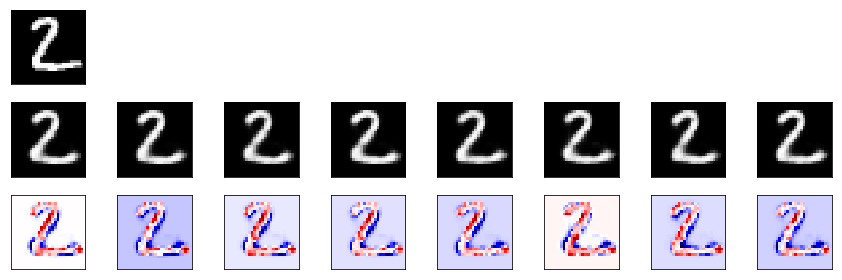

In [13]:
if make_20_small_only:
    show_multiple_draws(20, 'small')
else:
    for latents in [2, 20, 30, 50]:
        for size in ['small', 'big']:
            show_multiple_draws(latents, size)

In [14]:
def draw_predictions_set(num_latents, size):
    np.random.seed(random_seed)
    (latent_dim, VAE, encoder, generator) = get_VAE_models(num_latents, size)
    predictions = VAE.predict(X_test, batch_size=batch_size)
    plt.figure(figsize=(8, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.subplot(2, 5, i+6)
        plt.imshow(predictions[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 21s - loss: 157.5092 - val_loss: 124.3493
Epoch 2/25
60000/60000 [==============================] - 20s - loss: 119.1146 - val_loss: 113.5652
Epoch 3/25
60000/60000 [==============================] - 19s - loss: 112.2478 - val_loss: 109.3209
Epoch 4/25
60000/60000 [==============================] - 18s - loss: 108.9161 - val_loss: 106.8740
Epoch 5/25
60000/60000 [==============================] - 19s - loss: 106.9414 - val_loss: 105.5515
Epoch 6/25
60000/60000 [==============================] - 18s - loss: 105.5292 - val_loss: 104.3415
Epoch 7/25
60000/60000 [==============================] - 18s - loss: 104.4444 - val_loss: 103.6494
Epoch 8/25
60000/60000 [==============================] - 18s - loss: 103.6583 - val_loss: 102.7237
Epoch 9/25
60000/60000 [==============================] - 18s - loss: 103.0073 - val_loss: 102.6100
Epoch 10/25
60000/60000 [=========================

NameError: name 'file_helper' is not defined

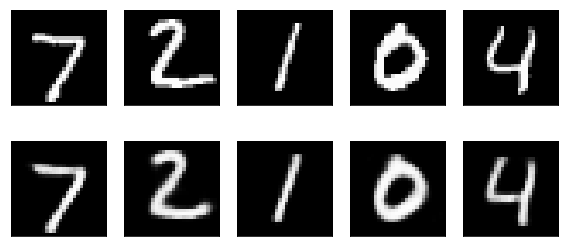

In [16]:
if make_20_small_only:
    draw_predictions_set(20, 'small')
else:
    for latents in [2, 20, 30, 50]:
        for size in ['small', 'big']:
            draw_predictions_set(latents, size)

In [17]:
# add some noise to MNIST text latent variables and show results
def draw_noisy_predictions(num_latents, size, noise_scale):
    np.random.seed(random_seed)
    plt.clf()
    (latent_dim, VAE, encoder, generator) = get_VAE_models(num_latents, size)
    predictions = encoder.predict(X_test, batch_size=batch_size)

    plt.figure(figsize=(8, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        latents = np.reshape(predictions[i], (1,latent_dim))
        for j in range(latent_dim):
            latents[0,j] += np.random.uniform(-noise_scale, noise_scale)
        decoder_prediction = generator.predict(latents)
        plt.subplot(2, 5, i+6)
        plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 18s - loss: 157.4482 - val_loss: 124.2651
Epoch 2/25
60000/60000 [==============================] - 17s - loss: 118.3838 - val_loss: 113.0285
Epoch 3/25
60000/60000 [==============================] - 16s - loss: 111.9747 - val_loss: 109.2730
Epoch 4/25
60000/60000 [==============================] - 15s - loss: 109.0375 - val_loss: 107.3933
Epoch 5/25
60000/60000 [==============================] - 15s - loss: 107.2553 - val_loss: 106.2745
Epoch 6/25
60000/60000 [==============================] - 16s - loss: 105.8341 - val_loss: 104.6284
Epoch 7/25
60000/60000 [==============================] - 15s - loss: 104.7363 - val_loss: 103.6483
Epoch 8/25
60000/60000 [==============================] - 16s - loss: 103.9586 - val_loss: 103.0892
Epoch 9/25
60000/60000 [==============================] - 15s - loss: 103.3319 - val_loss: 102.6672
Epoch 10/25
60000/60000 [=========================

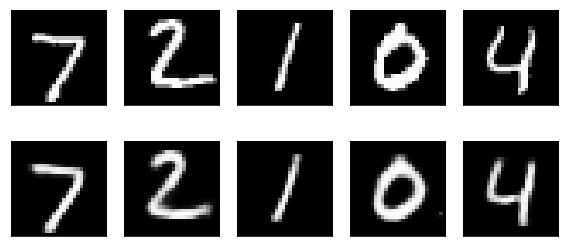

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 17s - loss: 157.7161 - val_loss: 123.6212
Epoch 2/25
60000/60000 [==============================] - 16s - loss: 118.5959 - val_loss: 113.2854
Epoch 3/25
60000/60000 [==============================] - 16s - loss: 111.9420 - val_loss: 108.8344
Epoch 4/25
60000/60000 [==============================] - 16s - loss: 108.8170 - val_loss: 107.1930
Epoch 5/25
60000/60000 [==============================] - 16s - loss: 106.9377 - val_loss: 105.9144
Epoch 6/25
60000/60000 [==============================] - 16s - loss: 105.5915 - val_loss: 104.5611
Epoch 7/25
60000/60000 [==============================] - 16s - loss: 104.5251 - val_loss: 103.4369
Epoch 8/25
60000/60000 [==============================] - 15s - loss: 103.7769 - val_loss: 102.7932
Epoch 9/25
60000/60000 [==============================] - 16s - loss: 103.0804 - val_loss: 102.6330
Epoch 10/25
60000/60000 [=========================

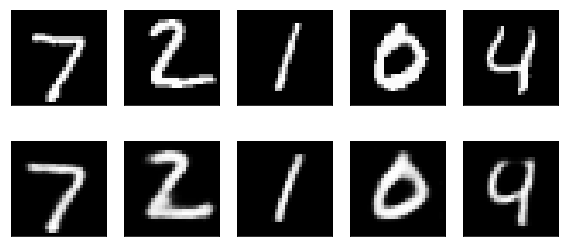

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 16s - loss: 157.4011 - val_loss: 124.1224
Epoch 2/25
60000/60000 [==============================] - 16s - loss: 118.7423 - val_loss: 112.7665
Epoch 3/25
60000/60000 [==============================] - 17s - loss: 111.6682 - val_loss: 108.8009
Epoch 4/25
60000/60000 [==============================] - 17s - loss: 108.4935 - val_loss: 107.0416 1
Epoch 5/25
60000/60000 [==============================] - 16s - loss: 106.6321 - val_loss: 105.8583
Epoch 6/25
60000/60000 [==============================] - 17s - loss: 105.3496 - val_loss: 104.5869
Epoch 7/25
60000/60000 [==============================] - 17s - loss: 104.3548 - val_loss: 103.4787
Epoch 8/25
60000/60000 [==============================] - 16s - loss: 103.6307 - val_loss: 102.5171
Epoch 9/25
60000/60000 [==============================] - 17s - loss: 103.0108 - val_loss: 102.5802
Epoch 10/25
60000/60000 [=======================

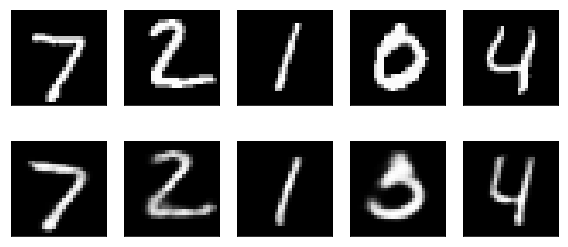

In [18]:
if make_20_small_only:
    for noise_scale in [.1, .5, 1.0]:
        draw_noisy_predictions(20, 'small', noise_scale)
else:
    for latents in [2, 20, 30, 50]:
        for size in ['small', 'big']:
            for noise_scale in [.1, .5, 1.0]:
                draw_noisy_predictions(latents, size, noise_scale)

In [19]:
def draw_blend_grid(num_latents, size):
    # blend latents for pairs of images and decompress
    
    plt.clf()
    (latent_dim, VAE, encoder, generator) = get_VAE_models(num_latents, size)
    predictions = encoder.predict(X_test, batch_size=batch_size)
    np.random.seed(random_seed)

    plt.figure(figsize=(8, 5))
    offset = 18
    for i in range(5):
        plt.subplot(3, 5, i+1)
        plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        plt.subplot(3, 5, i+6)
        plt.imshow(X_test[i+offset].reshape(28, 28), cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        plt.subplot(3, 5, i+11)
        
        pre0 = predictions[i]
        pre1 = predictions[i+offset]
        latent_list = np.zeros((1, len(pre0)))
        for j in range(len(pre0)):
            latent_list[0,j] = (pre0[j] + pre1[j])/2.0

        decoder_prediction = generator.predict(latent_list)
        plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 17s - loss: 156.1459 - val_loss: 122.9810
Epoch 2/25
60000/60000 [==============================] - 17s - loss: 117.8794 - val_loss: 112.9038
Epoch 3/25
60000/60000 [==============================] - 16s - loss: 111.5044 - val_loss: 109.0492
Epoch 4/25
60000/60000 [==============================] - 17s - loss: 108.6110 - val_loss: 107.2027
Epoch 5/25
60000/60000 [==============================] - 16s - loss: 106.8706 - val_loss: 105.3873
Epoch 6/25
60000/60000 [==============================] - 17s - loss: 105.5576 - val_loss: 104.8128
Epoch 7/25
60000/60000 [==============================] - 17s - loss: 104.6294 - val_loss: 103.9926
Epoch 8/25
60000/60000 [==============================] - 16s - loss: 103.8038 - val_loss: 103.3028
Epoch 9/25
60000/60000 [==============================] - 17s - loss: 103.2297 - val_loss: 102.8025 10
Epoch 10/25
60000/60000 [======================

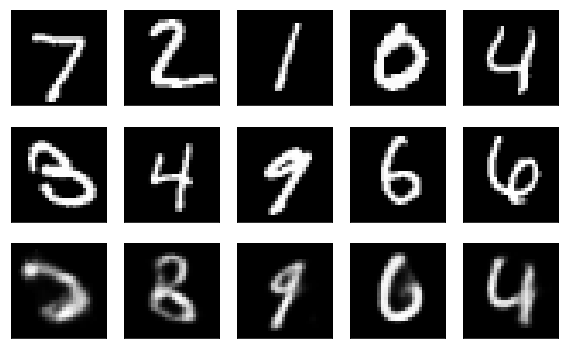

In [20]:
if make_20_small_only:
    draw_blend_grid(20, 'small')
else:
    for latents in [2, 20, 30, 50]:
        for size in ['small', 'big']:
            draww_blend_grid(latents, size)

In [21]:
def draw_linear_blend(num_latents, size, steps):
    # blend latents for two test images and decompress
    np.random.seed(random_seed)

    (latent_dim, VAE, encoder, generator) = get_VAE_models(num_latents, size)
    predictions = encoder.predict(X_test, batch_size=batch_size)
    
    start_list = [ predictions[4], predictions[23], predictions[29]]
    end_list = [ predictions[18], predictions[15], predictions[25]]
    plt.clf()
    plt.figure(figsize=(12, 5))
    num_rows = len(start_list)
    for row in range(num_rows):
        for i in range(steps):
            plt.subplot(num_rows, steps, (row*steps)+(i+1))
            alpha = i/(steps-1.0)
            latent_list = np.zeros((1, latent_dim))
            for j in range(latent_dim):
                latent_list[0,j] = start_list[row][j] + (alpha * (end_list[row][j] - start_list[row][j]))
                decoder_prediction = generator.predict(latent_list)
                plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
                ax = plt.gca()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 20s - loss: 157.3298 - val_loss: 123.9925
Epoch 2/25
60000/60000 [==============================] - 20s - loss: 118.7011 - val_loss: 113.1365 118.7 - ETA: 0s - loss: 118.72
Epoch 3/25
60000/60000 [==============================] - 19s - loss: 111.8192 - val_loss: 108.8712
Epoch 4/25
60000/60000 [==============================] - 18s - loss: 108.6526 - val_loss: 106.7811
Epoch 5/25
60000/60000 [==============================] - 16s - loss: 106.7358 - val_loss: 105.7689
Epoch 6/25
60000/60000 [==============================] - 16s - loss: 105.4044 - val_loss: 104.2682
Epoch 7/25
60000/60000 [==============================] - 19s - loss: 104.4223 - val_loss: 103.6571
Epoch 8/25
60000/60000 [==============================] - 16s - loss: 103.6484 - val_loss: 102.7654
Epoch 9/25
60000/60000 [==============================] - 16s - loss: 102.9913 - val_loss: 102.7103
Epoch 10/25
60000/6

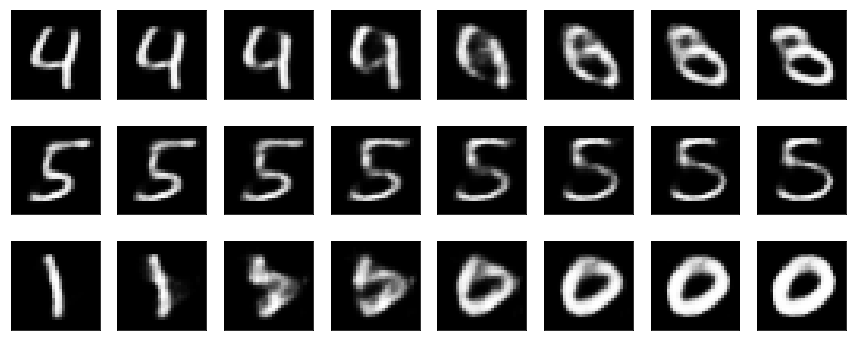

In [22]:
if make_20_small_only:
    draw_linear_blend(20, 'small', 8)
else:
    for latents in [2, 20, 30, 50]:
        for size in ['small', 'big']:
            draw_linear_blend(latents, size, 8)

In [23]:
def draw_VAE_scatter(size, marker_scale=1):
    np.random.seed(random_seed)
    # we only draw these for 2D versions
    (latent_dim, VAE, encoder, generator) = get_VAE_models(2, size)

    clrs = [ 'red', 'sandybrown', 'sienna', 'gold', 'palegreen',
            'limegreen', 'deepskyblue', 'blue', 'plum', 'magenta' ]
    
    plt.clf()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, aspect='equal')

    c = patches.Ellipse((0,0), 6, 6, edgecolor='black', fill=False)
    ax.add_patch(c)
    
    latent_list = encoder.predict(X_test, batch_size=batch_size)
    for i in range(len(latent_list)):
        mx = latent_list[i,0]
        my = latent_list[i,1]
        vx = marker_scale
        vy = marker_scale
        p = patches.Ellipse((mx,my), marker_scale, marker_scale,
                            edgecolor='none', facecolor=clrs[y_test[i]])
        ax.add_patch(p)
        
    handle_list = []
    for i in range(10):
        p = patches.Patch(color=clrs[i], label=str(i))
        handle_list.append(p)
    ax.legend(handles=handle_list, loc='lower right', shadow=True)
    
    ax.set_ylim([np.min(latent_list[:,1]), np.max(latent_list[:,1])])
    ax.set_xlim([np.min(latent_list[:,0]), np.max(latent_list[:,0])])

    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    

    plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 15s - loss: 185.6060 - val_loss: 166.5945
Epoch 2/25
60000/60000 [==============================] - 15s - loss: 163.0648 - val_loss: 160.2017
Epoch 3/25
60000/60000 [==============================] - 15s - loss: 157.9220 - val_loss: 156.8948
Epoch 4/25
60000/60000 [==============================] - 15s - loss: 154.6457 - val_loss: 152.9511
Epoch 5/25
60000/60000 [==============================] - 15s - loss: 152.1299 - val_loss: 150.9725
Epoch 6/25
60000/60000 [==============================] - 15s - loss: 150.2010 - val_loss: 149.2498
Epoch 7/25
60000/60000 [==============================] - 15s - loss: 148.7404 - val_loss: 148.4286
Epoch 8/25
60000/60000 [==============================] - 15s - loss: 147.5214 - val_loss: 147.5875
Epoch 9/25
60000/60000 [==============================] - 15s - loss: 146.7448 - val_loss: 146.7581 146.7
Epoch 10/25
60000/60000 [===================

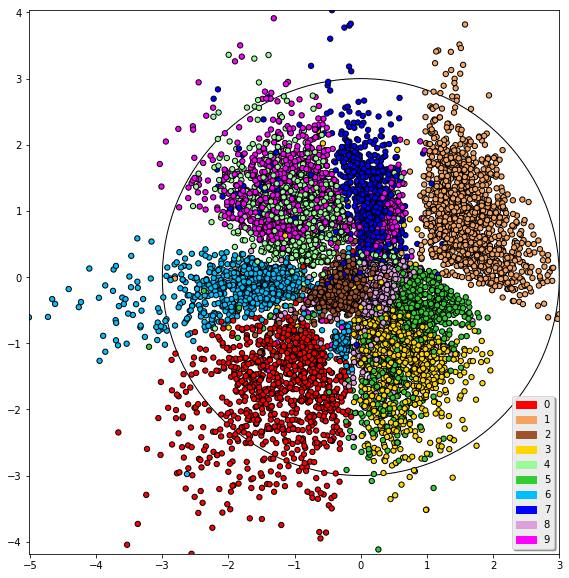

In [24]:
draw_VAE_scatter('small', marker_scale=.08)

In [25]:
def draw_VAE_decoder_grid(size, steps=17):
    (latent_dim, VAE, encoder, generator) = get_VAE_models(2, size)

    # display a 2D manifold of the digits
    digit_size = 28
    figure = np.zeros((digit_size * steps, digit_size * steps))
    # generate inputs to match up with the scatter plot 
    grid_x = np.linspace(2, -2, steps)
    grid_y = np.linspace(-2, 2, steps)

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = generator.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    ax = plt.gca()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    plt.imshow(figure, cmap='gray')
    plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 16s - loss: 182.7144 - val_loss: 164.1822
Epoch 2/25
60000/60000 [==============================] - 17s - loss: 161.1362 - val_loss: 158.3860
Epoch 3/25
60000/60000 [==============================] - 18s - loss: 156.1515 - val_loss: 154.2099
Epoch 4/25
60000/60000 [==============================] - 17s - loss: 152.8096 - val_loss: 151.2880
Epoch 5/25
60000/60000 [==============================] - 17s - loss: 150.4341 - val_loss: 149.2386
Epoch 6/25
60000/60000 [==============================] - 18s - loss: 148.6987 - val_loss: 147.9740
Epoch 7/25
60000/60000 [==============================] - 18s - loss: 147.4599 - val_loss: 147.3142
Epoch 8/25
60000/60000 [==============================] - 16s - loss: 146.3245 - val_loss: 146.3256
Epoch 9/25
60000/60000 [==============================] - 16s - loss: 145.4533 - val_loss: 145.4696
Epoch 10/25
60000/60000 [=========================

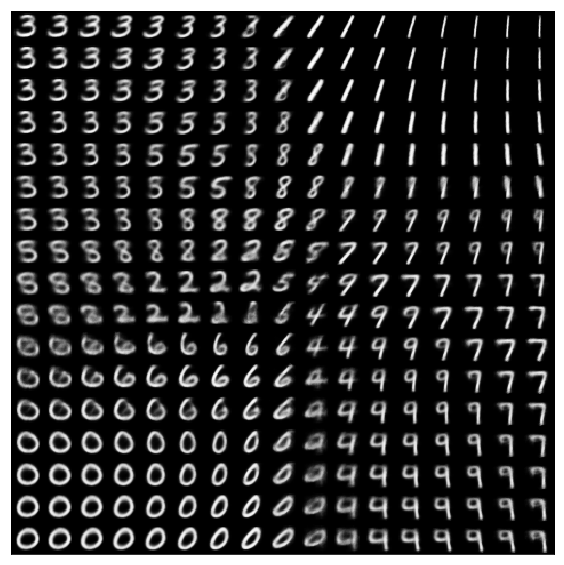

In [26]:
draw_VAE_decoder_grid('small', 17)

In [27]:
# drive the VAE with random latent variables and see what comes out
def draw_random_VAE(num_latents, size, noise_range):
    (latent_dim, VAE, encoder, generator) = get_VAE_models(num_latents, size)
    
    np.random.seed(random_seed)
    plt.figure(figsize=(10, 8))
    rows = 8
    cols = 10
    for y in range(rows):
        for x in range(cols):
            plt.subplot(rows, cols, 1+x+(y*cols))
            latents = np.random.uniform(-noise_range, noise_range, (1, latent_dim))
            decoder_prediction = generator.predict(latents)
            plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 16s - loss: 184.1458 - val_loss: 165.8125
Epoch 2/25
60000/60000 [==============================] - 16s - loss: 161.0325 - val_loss: 156.8389
Epoch 3/25
60000/60000 [==============================] - 15s - loss: 155.0005 - val_loss: 153.1601
Epoch 4/25
60000/60000 [==============================] - 15s - loss: 151.8398 - val_loss: 150.5557
Epoch 5/25
60000/60000 [==============================] - 18s - loss: 149.7236 - val_loss: 148.9686
Epoch 6/25
60000/60000 [==============================] - 17s - loss: 147.9626 - val_loss: 147.3648
Epoch 7/25
60000/60000 [==============================] - 17s - loss: 146.7465 - val_loss: 146.0877
Epoch 8/25
60000/60000 [==============================] - 17s - loss: 145.4715 - val_loss: 145.5037
Epoch 9/25
60000/60000 [==============================] - 16s - loss: 144.5552 - val_loss: 144.5563
Epoch 10/25
60000/60000 [=========================

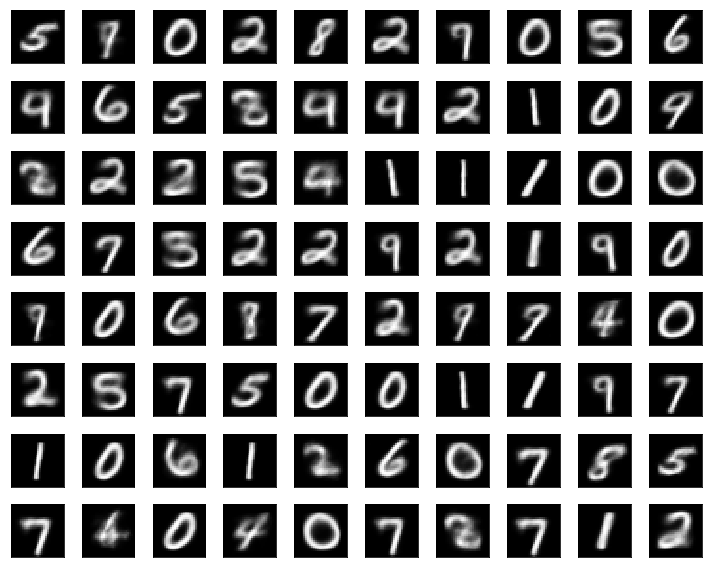

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 16s - loss: 157.7625 - val_loss: 124.0945
Epoch 2/25
60000/60000 [==============================] - 15s - loss: 118.5560 - val_loss: 112.8129
Epoch 3/25
60000/60000 [==============================] - 15s - loss: 111.7587 - val_loss: 109.0321
Epoch 4/25
60000/60000 [==============================] - 15s - loss: 108.7587 - val_loss: 106.9978
Epoch 5/25
60000/60000 [==============================] - 15s - loss: 106.8829 - val_loss: 105.5140
Epoch 6/25
60000/60000 [==============================] - 15s - loss: 105.5821 - val_loss: 105.0022
Epoch 7/25
60000/60000 [==============================] - 16s - loss: 104.5781 - val_loss: 103.8587
Epoch 8/25
60000/60000 [==============================] - 19s - loss: 103.8152 - val_loss: 103.0916
Epoch 9/25
60000/60000 [==============================] - 17s - loss: 103.1343 - val_loss: 102.6813
Epoch 10/25
60000/60000 [=========================

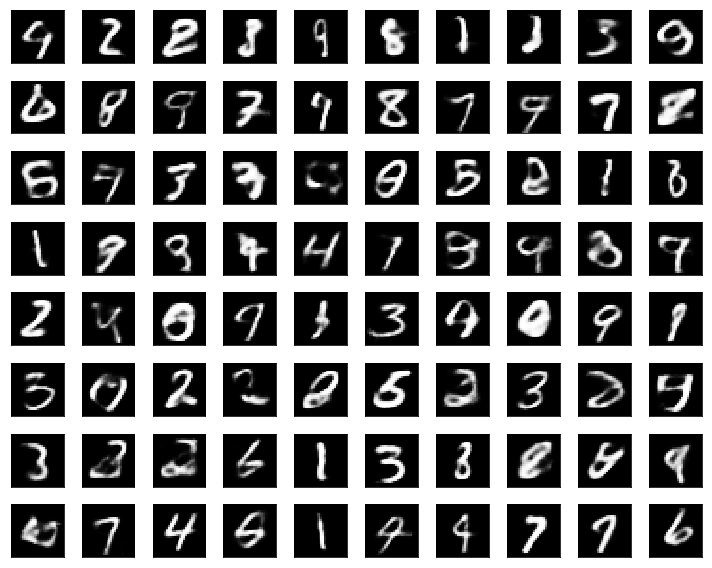

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 45s - loss: 180.0407 - val_loss: 144.6133
Epoch 2/25
60000/60000 [==============================] - 42s - loss: 133.7375 - val_loss: 125.6647
Epoch 3/25
60000/60000 [==============================] - 41s - loss: 123.2427 - val_loss: 120.0718
Epoch 4/25
60000/60000 [==============================] - 41s - loss: 119.2032 - val_loss: 118.0391
Epoch 5/25
60000/60000 [==============================] - 44s - loss: 116.5644 - val_loss: 115.3339
Epoch 6/25
60000/60000 [==============================] - 44s - loss: 114.7274 - val_loss: 113.8801
Epoch 7/25
60000/60000 [==============================] - 42s - loss: 113.0529 - val_loss: 112.8098
Epoch 8/25
60000/60000 [==============================] - 41s - loss: 111.7843 - val_loss: 111.4254
Epoch 9/25
60000/60000 [==============================] - 41s - loss: 110.5000 - val_loss: 110.5385
Epoch 10/25
60000/60000 [=========================

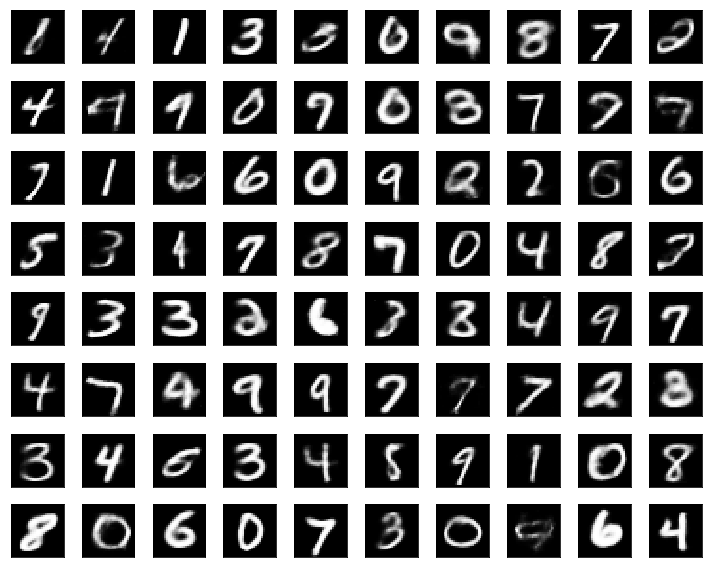

In [28]:
if make_20_small_only:
    draw_random_VAE(2, 'small', 2)
    draw_random_VAE(20, 'small', 2)
    draw_random_VAE(50, 'big', 2)  # not really 20_small but we want both
else:
    for latents in [2, 20, 30, 50]:
        for size in ['small', 'big']:
            draw_random_VAE(latents, size, 3)